In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
#import datasets
import numpy as np

pl.seed_everything(89026614)

#text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614


In [54]:
device = "mps"
block_size = 100
test_size = 1500
batch_size = 64

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [55]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=44, num_layers=5):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )

    def forward(self, x):
        B, T, C = x.shape
        x = x + F.tanh(self.q(x)) * F.pad(x[:, :T-1, :], (0, 0, 1, 0))
        x = x + self.mlp(x)
        return x

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long).unsqueeze(0).to(self.device)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=30, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 95.9 K
-------------------------------
95.9 K    Trainable params
0         Non-trainable params
95.9 K    Total params
0.384     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 71.11it/s]And nowR"sB=4B'Xö&Pt'WY<9JBR!DONYEj !BMc'HwE
"94ö"Nf&PBATJP"0>2Rg30>.a!
Epoch 0: 100%|██████████| 118/118 [00:02<00:00, 48.18it/s, loss=1.71, v_num=156]And now wook castot by told slowes, attle.

"Oh, be was are here of tha
Epoch 5: 100%|██████████| 118/118 [00:02<00:00, 49.27it/s, loss=1.45, v_num=156, test_loss=1.500]And now wage, where a picker, the water?"

"Ay thardade a pile out with
Epoch 9: 100%|██████████| 118/118 [00:02<00:00, 47.68it/s, loss=1.41, v_num=156, test_loss=1.410]And now," were of the such of the mud he had hurreatonisks.

"But made 
Epoch 10: 100%|██████████| 118/118 [00:02<00:00, 47.27it/s, loss=1.38, v_num=156, test_loss=1.410]And now.

So, if through trandma Bow, off.

She careful had and two mea
Epoch 12: 100%|██████████| 118/118 [00:02<00:00, 46.37it/s, loss=1.37, v_num=156, test_loss=1.390]And now!"

Jonas were a scrab.

She had been hook," was. I will got him
Epoch 17: 100%|████████

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 118/118 [00:02<00:00, 41.90it/s, loss=1.31, v_num=156, test_loss=1.270]


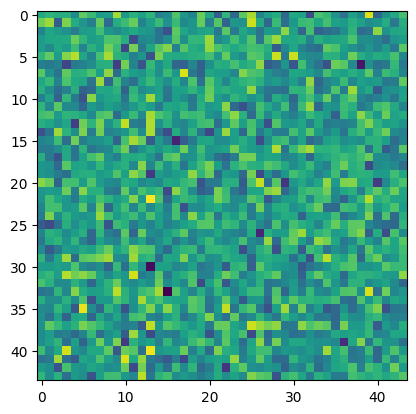

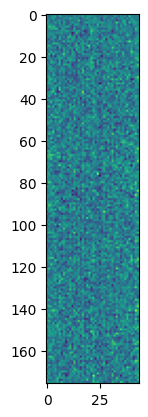

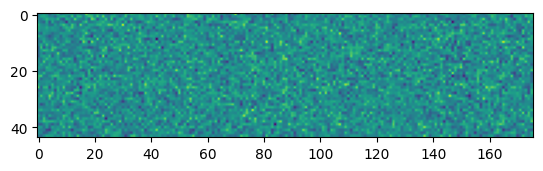

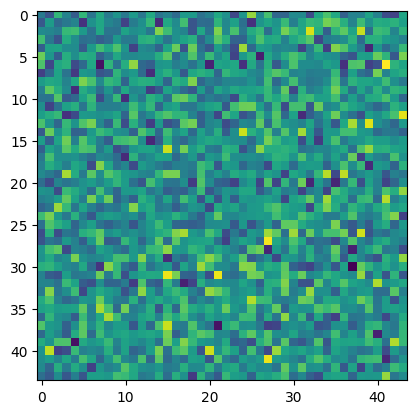

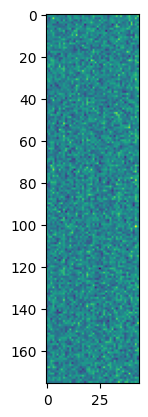

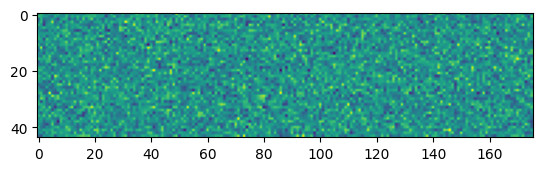

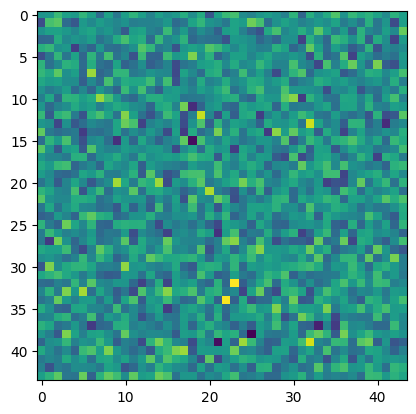

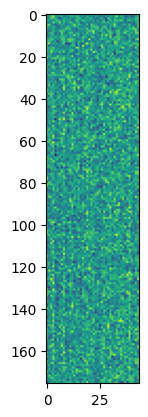

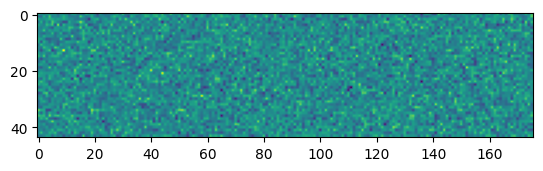

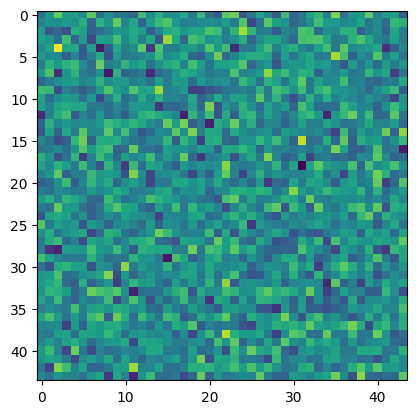

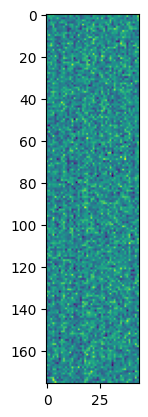

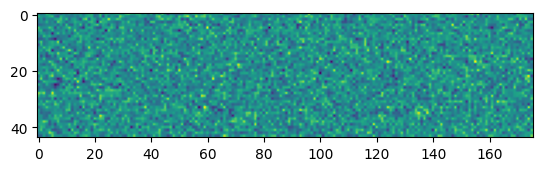

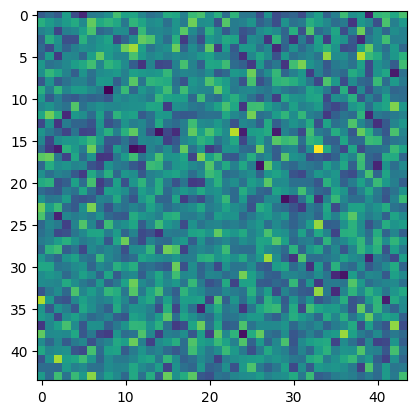

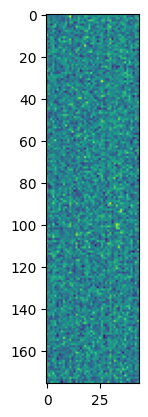

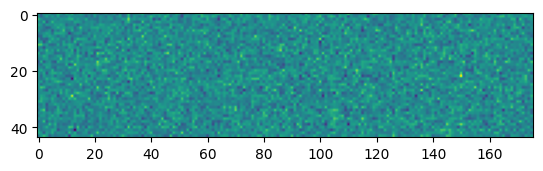

In [56]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.q.weight.detach())
    plt.figure()
    plt.imshow(b.mlp[0].weight.detach())
    plt.figure()
    plt.imshow(b.mlp[2].weight.detach())

In [57]:
print(model.generate("O God, O God!", 650))

O God, O God!" sance hared-went on that she's no one in the strong," asked to make-believe time, but he saw they had hall what the two father.

"I will get him."

"I've came to fives had happened.

"Oh, trying after a shot with which was a good boy who drew way have says, the foolishing. Now I did not this cut on the herd is the fared there aren't got backs he islens and then she did not speed, but ha! Oh, I though the boys, and over here we cage when they are you must kneems home the sporter, who will get me and did not far in the hen, and that it,

"Then the care anything to seen the while highed to stayed in my men ware for? As far, the train for me, w
